In [3]:
%load_ext autoreload
%autoreload 3 --print

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from kpsn.project.paths import Project, create_model
from kpsn.io import loaders
from kpsn.models import joint
from kpsn import config
from kpsn.models import instantiation, setup, pose, morph, util as model_util
from kpsn import fitting
from kpsn.fitting import em
from kpsn.io import alignment, features
from kpsn.io.armature import Armature
from kpsn.fitting import methods
from kpsn.fitting import scans
import os, sys, shutil
from pprint import pprint
from kpsn import viz
from kpsn.viz import styles
import matplotlib.pyplot as plt

import logging
logging.getLogger().setLevel(logging.INFO)

### Project setup

In [5]:
project_dir = '../projects/keypt-space'
project = Project(project_dir)

if os.path.exists(project_dir): shutil.rmtree(project_dir)
if not os.path.exists(project_dir):
    loaders.raw_npy.setup_project_config(
        project,
        filepaths = {
            '24wk_m3': '../../../data_explore/data/11_03_22_24wk_m3.npy',
            '5wk_m6': '../../../data_explore/data/10_24_22_5wk_m6.npy'},
        ref_session = '24wk_m3',
        keypoint_names = [
            'shldr', 'back', 'hips', 't_base','t_tip', 'head',
            'l_ear', 'r_ear', 'nose', 'lr_knee', 'lr_foot',
            'rr_knee', 'rr_foot', 'lf_foot', 'rf_foot'],
        keypoint_parents = [
            'back', 'hips', None, 'hips', 'shldr',
            'head', 'head', 'head', 'hips', 'lr_knee',
            'hips', 'rr_knee', 'shldr', 'shldr'],
        exclude_keypoints = ['t_tip'],
        subsample = 10,
        feature_type='bones',)
    
    setup.setup_base_model_config(project.main_config(), project.base_model_config(),
        morph_type='bone_length')

(project.root() / "plots").mkdir(exist_ok=True)
plotter, colors = styles.init_nb(str(project.root() / "plots"), style = "vscode_dark")

In [6]:
# --- calibration: alignment and feature reduction
cfg = config.load_project_config(project.main_config())
dataset = loaders.raw_npy.load(cfg["dataset"])

dataset, cfg = loaders.raw_npy.default_alignment.calibrate(
    dataset, cfg, origin="hips", anterior="head"
)

cfg = features.bones.calibrate(dataset, cfg)
dataset = features.reduce_to_features(dataset, cfg["features"])
config.save_project_config(project.main_config(), cfg, write_calib=True)

# --- calibration: pose and morph models
cfg = config.load_model_config(project.base_model_config())
cfg["fit"]["n_steps"] = 400

# cfg = pose.gmm.calibrate_base_model(dataset, cfg, n_components=20) ### !! for poseL20 project
cfg = pose.gmm.calibrate_base_model(dataset, cfg, n_components=3)
cfg = morph.bone_length.calibrate_base_model(dataset, cfg)
cfg = em.calibrate_base_model(dataset, cfg)
config.save_model_config(project.base_model_config(), cfg, write_calib=True)

../projects/keypt-space/plots/pose_calibration.png


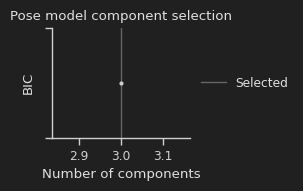

In [7]:
cfg = config.load_model_config(project.base_model_config())

figs = viz.model.plot_calibration(cfg)
# plotter.finalize(figs["morph"], "morph_calibration")
plotter.finalize(figs["pose"], "pose_calibration")

### Single model

In [10]:
model_dir, cfg = create_model(
    project,
    "first_run",
    config_overrides={
        "fit.learning_rate": 4e0,
        "fit.n_steps": 40,
    },
)
fit_data = methods.fit(
    project.model("first_run"),
    log_every=1,
)

INFO:root:Continuing from checkpoint at step 4.
INFO:root:Adjusting learning rate:4.0 -> 0.0005567153792623522
INFO:root:Loading LR schedule: const
INFO:root:Step 5 : loss = -566477.5625
INFO:root:Step 6 : loss = -566534.0
INFO:root:Step 7 : loss = -566676.3125
INFO:root:Step 8 : loss = -566735.25
INFO:root:Step 9 : loss = -566774.0
INFO:root:Step 10 : loss = -566867.6875
INFO:root:Step 11 : loss = -566936.9375
INFO:root:Step 12 : loss = -567007.8125
INFO:root:Step 13 : loss = -567067.6875
INFO:root:Step 14 : loss = -567097.1875
INFO:root:Step 15 : loss = -567131.75
INFO:root:Step 16 : loss = -567160.375
INFO:root:Step 17 : loss = -567179.375
INFO:root:Step 18 : loss = -567190.3125
INFO:root:Step 19 : loss = -567195.875
INFO:root:Step 20 : loss = -567208.6875
INFO:root:Step 21 : loss = -567206.5625
INFO:root:Step 22 : loss = -567215.0
INFO:root:Step 23 : loss = -567221.5
INFO:root:Step 24 : loss = -567228.875
INFO:root:Step 25 : loss = -567234.125
INFO:root:Step 26 : loss = -567236.875

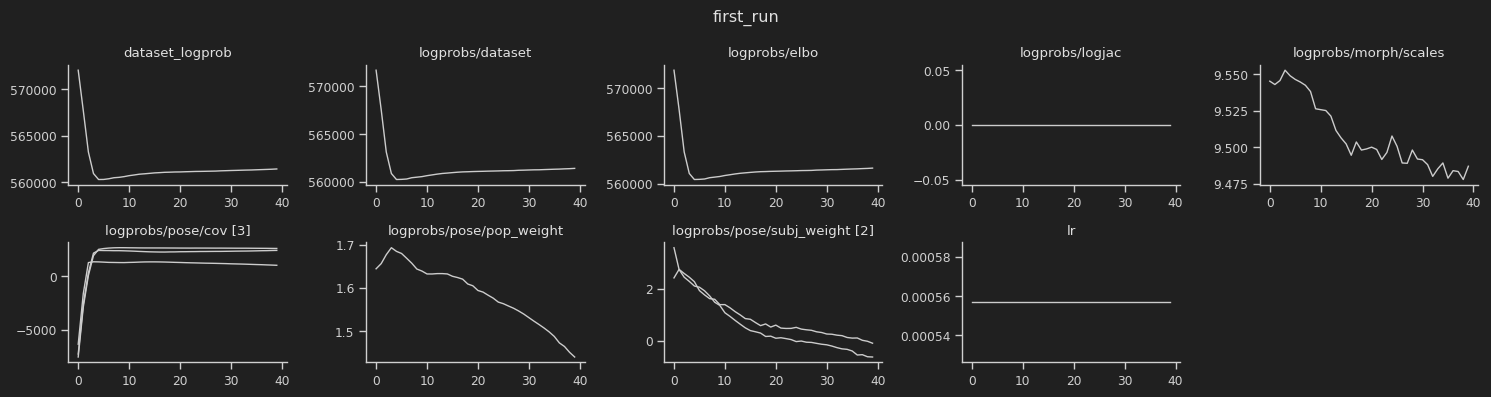

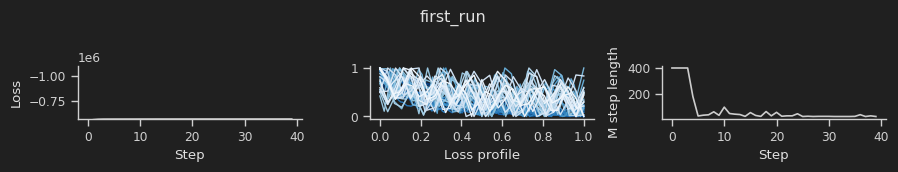

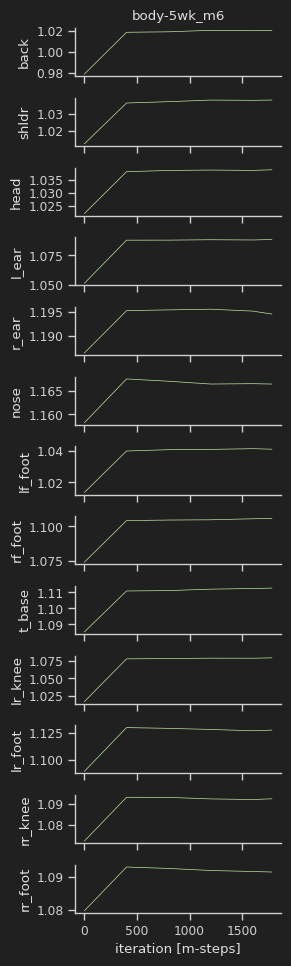

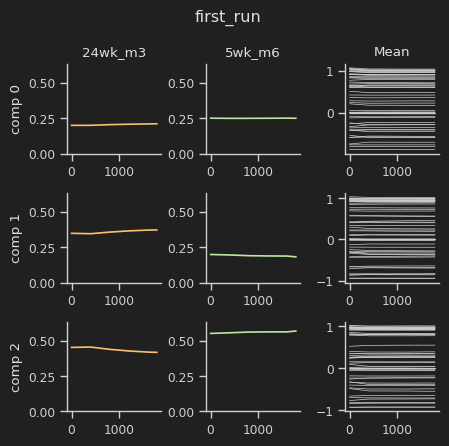

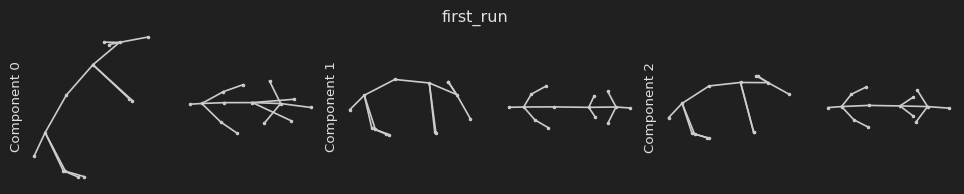

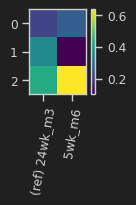

In [11]:
model_name = "first_run"
ckpt = methods.load_fit(project.model(model_name))
fig = viz.model.report_plots(ckpt)
fig.suptitle(model_name)
plotter.finalize(fig, None)

ckpt = methods.load_fit(project.model(model_name))
fig = viz.model.em_loss(ckpt)
fig.suptitle(model_name)
plotter.finalize(fig, None)

ckpt = methods.load_fit(project.model(model_name))
fig = viz.model.bls_param_convergence(ckpt)
plotter.finalize(fig, None)

ckpt = methods.load_fit(project.model(model_name))
fig = viz.model.gmm_param_convergence(ckpt)
fig.suptitle(model_name)
plotter.finalize(fig, None)

ckpt = methods.load_fit(project.model(model_name))
mean_fig, wt_fig = viz.model.gmm_components(ckpt)
mean_fig.suptitle(model_name)
plotter.finalize(fig, None)

### How would you even run this?

In [26]:
# can you pytree a keypoint dataset?
from kpsn.io.dataset import KeypointDataset, PytreeDataset
dataset, align_inv = methods.load_and_prepare_dataset(cfg, all_versions=True)
aligned = dataset["aligned"]
pt_obs = PytreeDataset.from_pythonic(aligned)
reconst = KeypointDataset.from_pytree(pt_obs, aligned._body_names, aligned._session_names, aligned.keypoint_names)

### Bone-length alignment